In [1]:
# lib to handle with time series
import pandas as pd
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from pmdarima.arima import auto_arima, arima
# from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
import pmdarima as pm


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6


import warnings
warnings.filterwarnings("ignore")

In [2]:
# to read the time series
df = pd.read_csv('sp.txt', delimiter='\t', header=None)
# df['Month'] = pd.to_datetime(df['Month'])
# df.set_index('Month', drop=True, inplace=True)
df

,0
0,4.445940
1,4.500187
2,4.504543
3,4.413004
4,4.353499
...,...
364,8.354767
365,8.379121
366,8.363364
367,8.423626


In [3]:
df.dtypes

0    float64
dtype: object

<Axes: >

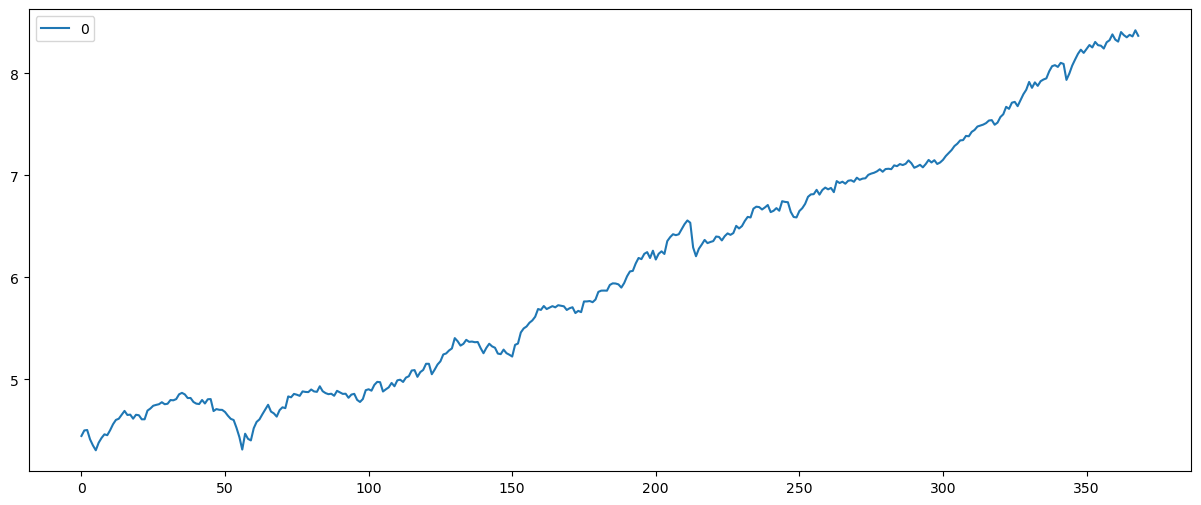

In [4]:
df.plot()

Text(0.5, 1.0, 'SP')

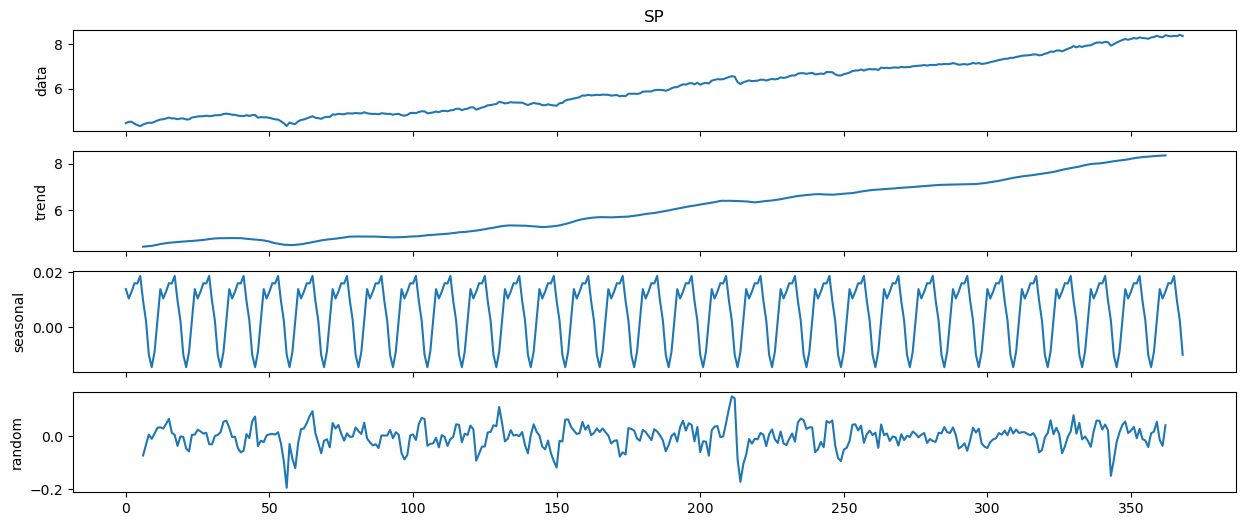

In [5]:
from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

figure_kwargs = {'figsize': (15, 6)}  #
# Decompose the airpassengers dataset into trend, seasonal and random parts.
decomposed = arima.decompose(df.values.reshape(-1),
                             'additive', m=12)

# Plot the decomposed signal of airpassengers as a subplot

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("SP")

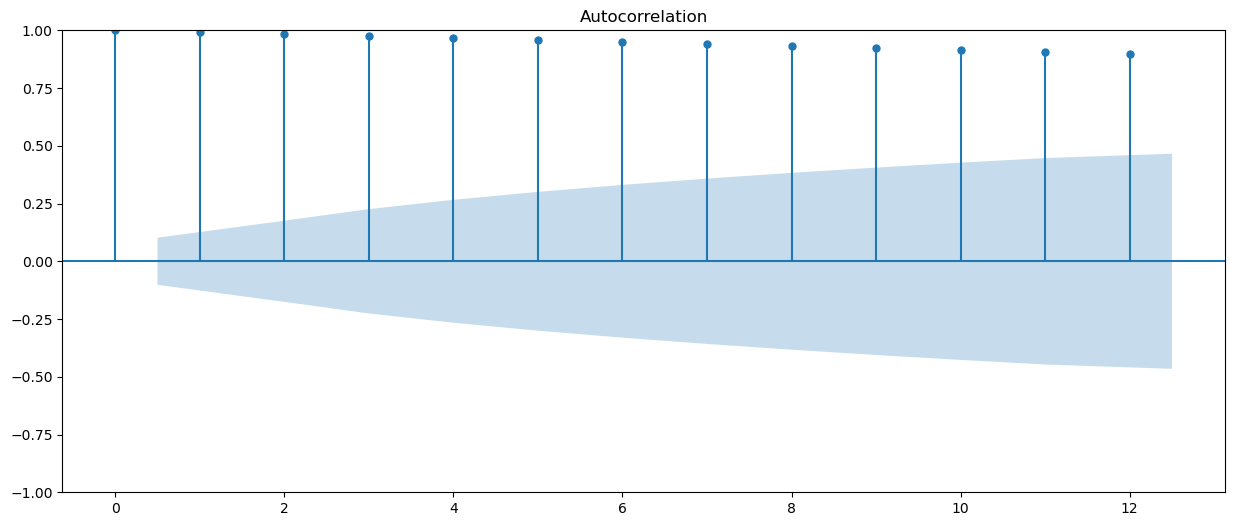

In [6]:
# to use the acf
plot_acf(df, lags=12)
plt.show()

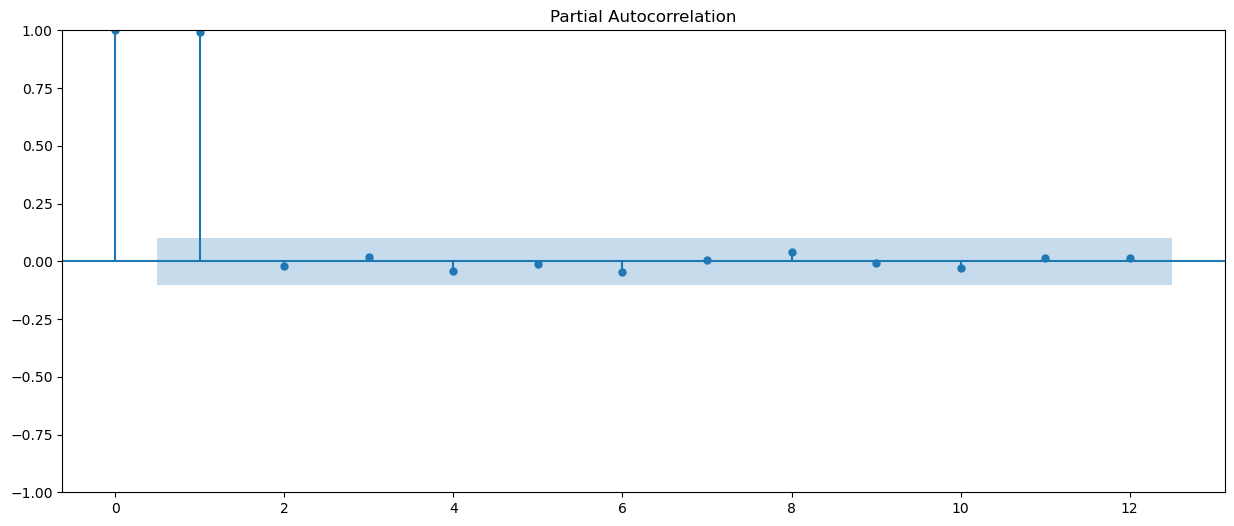

In [7]:
# to use the pacf
plot_pacf(df, lags=12)
plt.show()

In [8]:
# plot_acf(decomposed[3], lags=12)
# plt.show()

## Modelagem (AR, MA, ARIMA)

### Teste de Estacionarieade

In [9]:
# Test for stationarity using the Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[1] <= 0.05:
    print('The data is stationary.')
else:
    print('The data is non-stationary.')


ADF Statistic: 1.0023364374668782
p-value: 0.9942905396061543
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
The data is non-stationary.


In [10]:
m=12
test_size=12
y = df.values
train_len = len(y) - test_size

In [11]:
#Normalização
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(y[0:train_len].reshape(-1, 1))
serie_normalized = min_max_scaler.transform(y.reshape(-1, 1)).flatten()


In [12]:
y_train, y_test = train_test_split(serie_normalized, train_size=train_len)
print("train_size", len(y_train))
print("test_size", len(y_test))

train_size 357
test_size 12


## Outras Transformações

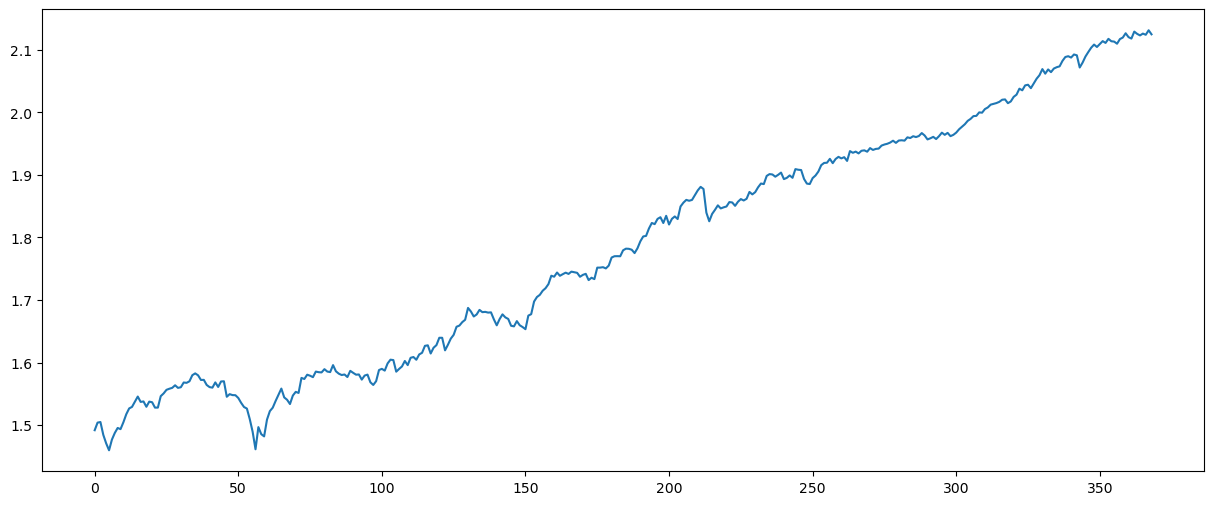

In [13]:
# Log
y_log = np.log(y)
plt.plot(y_log)

### AR

In [14]:
model_AR = pm.arima.ARIMA(order=(2,0,0))
model_AR.fit(y_train)

ARIMA(order=(2, 0, 0))

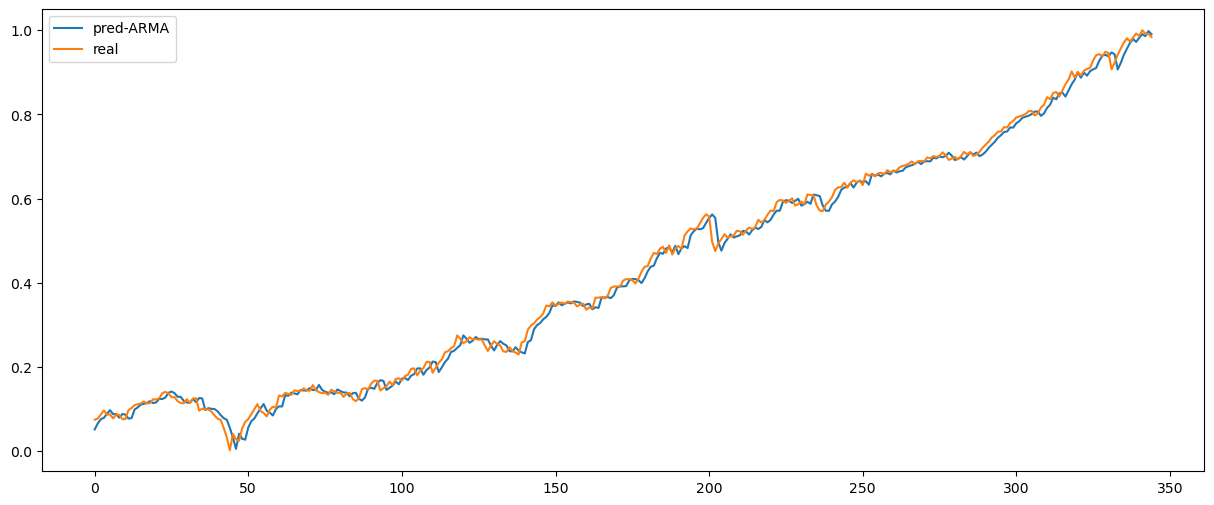

In [15]:
predictions_train_AR = model_AR.predict_in_sample()
plt.plot(predictions_train_AR[m:], label='pred-ARMA')
plt.plot(y_train[m:], label='real')
plt.legend()

In [16]:
def forecast_one_step():
    fc = model_AR.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]
    # np.asarray(conf_int).tolist()[0])

forecasts = []
# confidence_intervals = []

for new_ob in y_test:
    fc = forecast_one_step()
    forecasts.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_AR.update(new_ob)

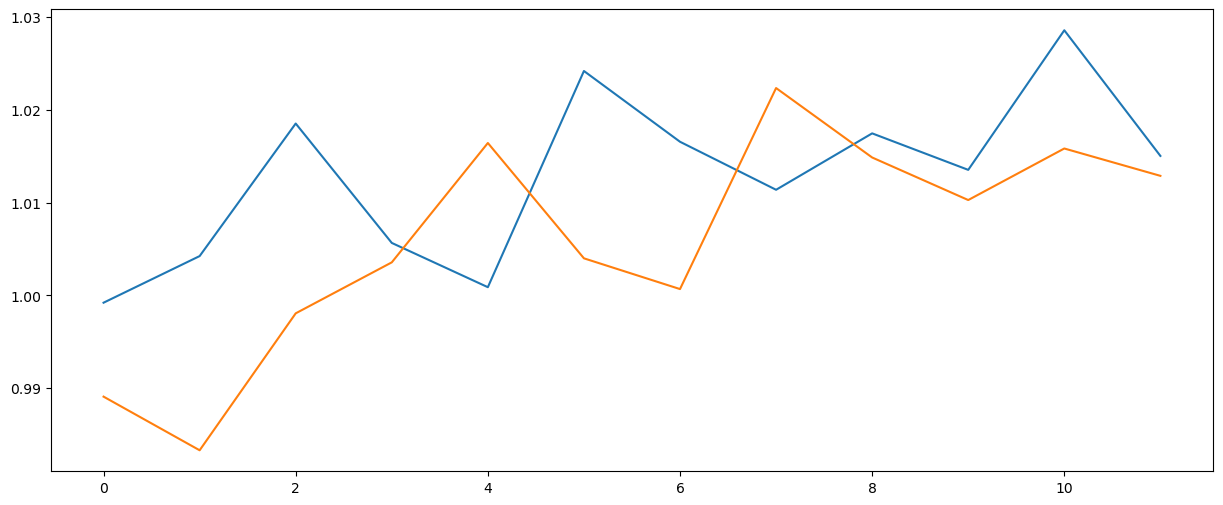

In [17]:
plt.plot(y_test)
plt.plot(forecasts)

In [18]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts))
print("Test MAE: %.10f" % mae(y_test, forecasts))

freq 12
Test MSE: 0.0001809740
Test MAE: 0.0114165718


### ARIMA

#### Diferenciação (I)

<Axes: >

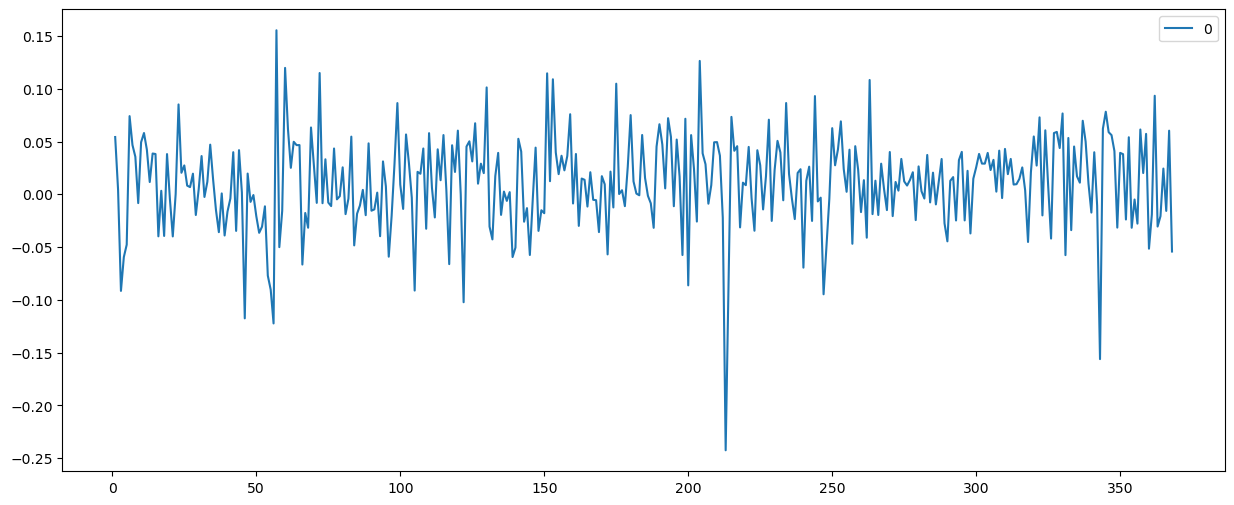

In [19]:
df_diff = df.diff(1)
df_diff.plot()

In [20]:
model_ARIMA = pm.arima.ARIMA(order=(2,1,1))
model_ARIMA.fit(y_train)

ARIMA(order=(2, 1, 1))

In [21]:
def forecast_one_step():
    fc = model_ARIMA.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]

forecasts_ARIMA = []
for new_ob in y_test:
    fc = forecast_one_step()
    forecasts_ARIMA.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_ARIMA.update(new_ob)

In [22]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts_ARIMA))
print("Test MAE: %.10f" % mae(y_test, forecasts_ARIMA))

freq 12
Test MSE: 0.0001388565
Test MAE: 0.0104222441


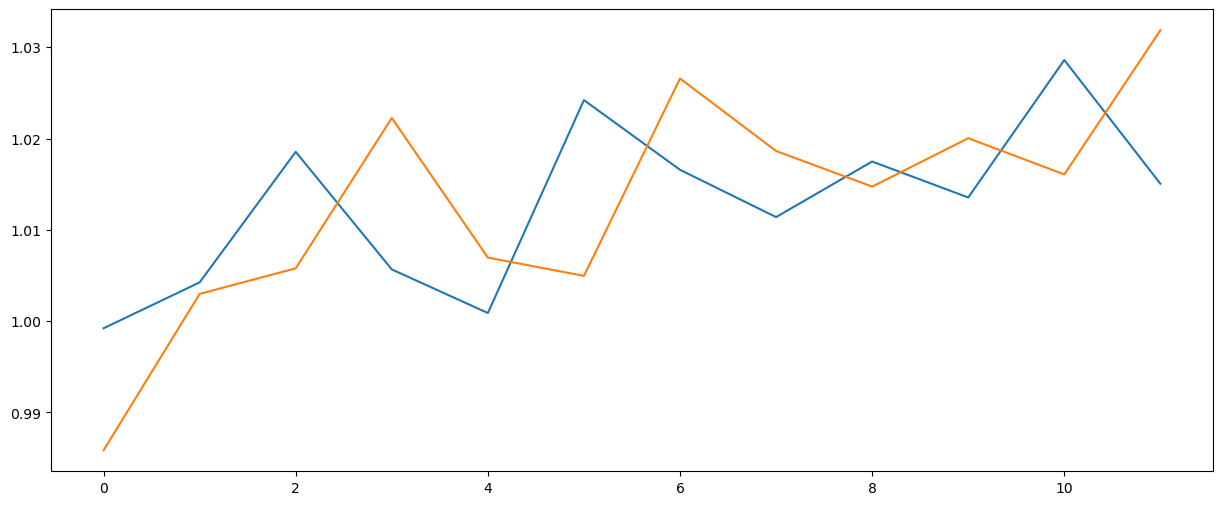

In [23]:
plt.plot(y_test)
plt.plot(forecasts_ARIMA)

### AUTO ARIMA

In [24]:
model_AutoARIMA = Pipeline(
    [
        ##('boxcox', BoxCoxEndogTransformer()),
        (
            "auto - arima",
            pm.AutoARIMA(
                trace=True,
                suppress_warnings=True,
                max_p=10,
                stepwise=True,
                seasonal=False,
                m=m,
            ),
        )
    ]
)

model_AutoARIMA.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2186.645, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2194.114, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2192.188, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2192.194, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2175.948, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2190.383, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.689 seconds


Pipeline(steps=[('auto - arima',
                 AutoARIMA(m=12, max_p=10, seasonal=False, trace=True))])

In [25]:
def forecast_one_step():
    fc = model_AutoARIMA.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]
forecasts_auto_ARIMA = []
for new_ob in y_test:
    fc = forecast_one_step()
    forecasts_auto_ARIMA.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_AutoARIMA.update(new_ob)

In [26]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts_auto_ARIMA))
print("Test MAE: %.10f" % mae(y_test, forecasts_auto_ARIMA))

freq 12
Test MSE: 0.0001389930
Test MAE: 0.0106000970
